In this notebook the eQTLs and pQTLs indentified with statistical package MatrixEQTL are analysed with respect to yeast interactome (various kinds of genetic and physical interactions, with particular emphasis on protein-protein interactions).

In [1]:
# TODO: Отрефакторить код (introduce consistent naming)
# TODO: Найти новые pQTLs 
#       1. Собрать подвыборку пар 
#       2. Запустить анализ в R
#       3. Доказать, что полученный результат не хуже
#           - пока что сохраняется всего 11% старых pQTLs
#           - несколько важных пиков в старых данных соответствуют неизвестным номенклатуре генам
#             (похоже, это не отдельные гены, а маркерные участки; что с этим делать?)  
#           - нужно попробовать запустить bfs на глубину 2 (существенного прироста числа найденных pQTLs не обнаружено)
#             с одной стороны, 25445 совпадений; с другой стороны, FDR-коррекция оставляет только 2000-4000 результатов в принципе.
# TODO: Выяснить причины
#       1. Почему исходный файл с генотипами дан в таком странном формате?
#          зачем там нумерация генов, зачем дубликаты, откуда неизвестные наименования? Почему их больше трёхсот?
#       2. Почему и близко не воспроизводятся заявленные в презентации результаты?
#       3. Почему данных стало больше, а результаты при этом хуже?
# Возникает стойкое ощущение, что я делаю что-то не то. 
# Для каждого гена я рассматриваю все пары (маркер, ген), где множество
# маркеров определяется как объединение множеств из его linkages и взаимодействующих с ним генов.
# Какие ещё логически могут быть варианты? Рассматривать для каждого гена ещё и linkages его соседей? 

%matplotlib inline

# utilities
from functools import partial
import time
import os

# data analysis tools
import random
import numpy as np
import pandas as pd
from scipy import stats
from statsmodels.sandbox.stats.multicomp import multipletests

# network analysis tools
import igraph as ig

# multiprocessing tools
import multiprocessing as mp


# visualization tools
import matplotlib.pyplot as plt
from matplotlib import cm

from lib import networks
from lib import qtls

%autosave 15

Autosaving every 15 seconds


In [2]:
random.seed(int(time.time()))
# 112 segregants genotyped by inherited marker variants
''' TODO: find out why markers were duplicated '''
full_genotypes_df = pd.read_table("./data/genotypes_in_std.csv")

''' Where possible, gene names were converted from systematic to standard notation '''
# mRNA expression and genotypes of strains the data is available for
eQTLs_expression_df = pd.read_table("./data/eQTLs/averaged_expression.csv")
eQTLs_genotypes_df = pd.read_table("./data/eQTLs/genotypes_in_std.csv")
# Protein expression and genotypes of strains the data is available for 
pQTLs_expression_df = pd.read_table("./data/pQTLs/averaged_expression.csv")
pQTLs_genotypes_df = pd.read_table("./data/pQTLs/genotypes_in_std.csv")


# Estimated QTLs
eQTLs_df = pd.read_table("./data/eQTLs/results_nodup.csv")
eQTLs_df = eQTLs_df[eQTLs_df["q.value"] <= 0.05]
pQTLs_df = pd.read_table("./data/pQTLs/results_nodup.csv")
pQTLs_df = pQTLs_df[pQTLs_df["q.value"] <= 0.05]


# Physical and genetic interactions taken from BioGrid project
full_interactome_df = pd.read_table("./data/yeast_interactome.csv")
# full_interactome_df = full_interactome_df[full_interactome_df['Publication year' <= 2011]]
genetic_interaction_categories = [
    "additive genetic interaction defined by inequality",
    "suppressive genetic interaction defined by inequality",
    "synthetic genetic interaction defined by inequality"
]
physical_interaction_categories = [
    "association",
    "colocalization",   
    "direct interaction",
    "physical association"
]
interaction_categories = genetic_interaction_categories + physical_interaction_categories
interactome_df = full_interactome_df.copy()
interactome_df.set_index('Interaction Type', inplace=True)
genetic_interactions_df = interactome_df[
    interactome_df.index.isin(genetic_interaction_categories)
]
physical_interactions_df = interactome_df[
    interactome_df.index.isin(physical_interaction_categories)
]
physical_interactions_graph = \
    networks.assemble_graph_of_interactions(
        physical_interactions_df[["Interactor A", "Interactor B"]].values
    )

genetic_interactions_graph = \
    networks.assemble_graph_of_interactions(
        genetic_interactions_df[["Interactor A", "Interactor B"]].values
    )


# Genetic nomenclature and mappings between different naming conventions
gene_nomenclature_df = pd.read_table("./data/yeast_gene_nomenclature_mapping.csv")
gene_nomenclature_df.drop_duplicates("Systematic name", inplace=True)
std_to_sys = dict(zip(
    gene_nomenclature_df["Standard name"].values, 
    gene_nomenclature_df["Systematic name"].values
))
sys_to_std = {v: k for k, v in std_to_sys.items()}

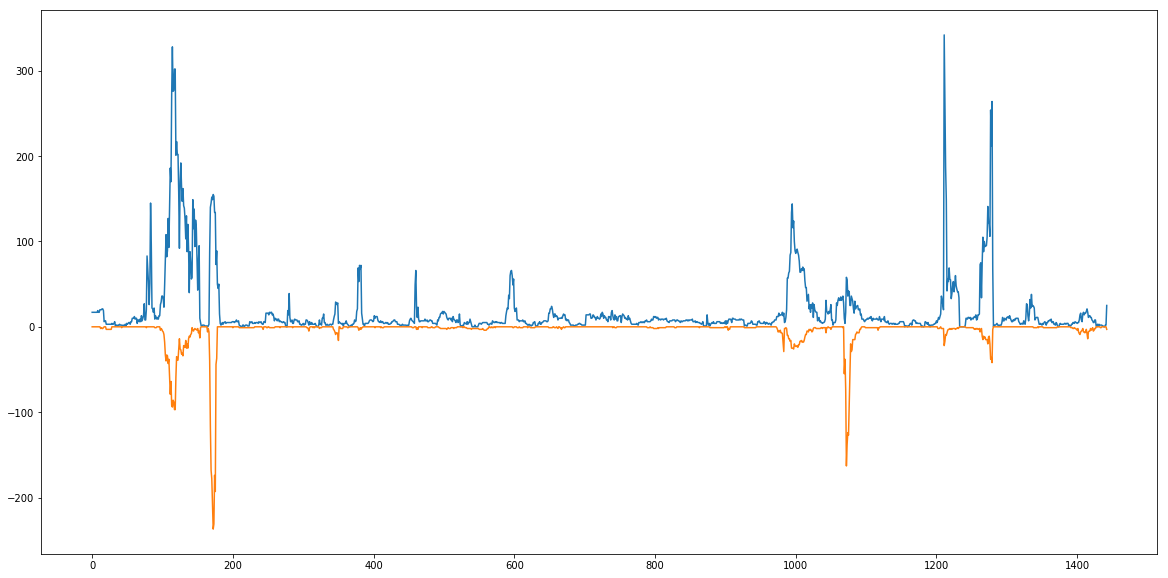

In [5]:
_, eQTL_y = qtls.map_linkages_to_genome_location(eQTLs_df, full_genotypes_df)
_, pQTL_y = qtls.map_linkages_to_genome_location(pQTLs_df, full_genotypes_df)

plt.figure(figsize=(20, 10))
plt.plot(eQTL_y)
plt.plot([-y for y in pQTL_y])
plt.savefig("./img/linkages/eQTLs_pQTLs_combined.png")


In [3]:
# Wouldn't it be better with query-syntax?

def get_interacting_genes(gene_name, interactions_graph, bfs_depth=1):
    try: 
        return set(interactions_graph.vs[
                   interactions_graph.neighborhood(gene_name, order=bfs_depth)
               ]["name"]
           )
    except:
        return set()
    
    
def get_linked_markers(gene_name, QTL_df):
    return set(QTL_df[QTL_df["gene"] == gene_name]["SNP"].values)


def get_linked_genes(marker_name, QTL_df):
    return set(QTL_df[QTL_df["SNP"] == marker_name]["gene"].values)

# speed this one up: string comparison is evil
def get_neighbor_linkages(gene_name):
    interacting_genes = {gene_name} | get_interacting_genes(gene_name, physical_interactions_graph) \
                        | get_interacting_genes(gene_name, genetic_interactions_graph)
    linked = set()
    for neighbor in interacting_genes:
        linked |= get_linked_markers(neighbor, eQTLs_df)
    return linked
        

In [5]:
# "Unknown" markers: I currently have no idea what they are.
# They cause problems, as they are not represented in interaction graphs.
unknown_markers = []
for marker_name in full_genotypes_df["SNP"].values:
    if std_to_sys.get(marker_name) == None:
        unknown_markers.append(
            (
                marker_name, 
                len(get_linked_genes(marker_name, eQTLs_df)),
                len(get_linked_genes(marker_name, pQTLs_df))
                    
            )
        )
# pd.DataFrame.to_csv(
#     pd.DataFrame(unknown_markers, columns=["SNP", "eQTL_linkages", "pQTL_linkages"]), 
#     "./data/unknown_markers.csv", sep='\t', index=False
# )

4302 0.6995121951219512


(array([ 128.,   11.,   11.,   18.,   14.,   23.,   23.,   22.,   40.,  320.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

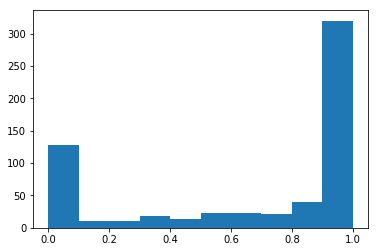

In [7]:
similarity_hist = []
possibly_common = 0
for gene_name in set(pQTLs_df["gene"].values):
    linked = get_neighbor_linkages(gene_name)
    # linked = get_linked_markers(gene_name, eQTLs_df)
    interacting = get_interacting_genes(gene_name, physical_interactions_graph) \
                    | get_interacting_genes(gene_name, genetic_interactions_graph) 
    # interacting = set()
    pQTLs = get_linked_markers(gene_name, pQTLs_df)
    possibly_common += len((interacting | linked) & pQTLs)
    similarity_hist.append(float(len((interacting | linked) & pQTLs)) / len(pQTLs))
print(possibly_common, possibly_common / pQTLs_df.shape[0])
plt.hist(similarity_hist)

In [20]:
valid_markers = set(pQTLs_genotypes_df["SNP"].values)
possible_linkages = []
for gene_name in pQTLs_expression_df["gene"].values:
    linked = get_neighbor_linkages(gene_name)
    # linked = set()
    interacting = get_interacting_genes(gene_name, physical_interactions_graph) \
                  | get_interacting_genes(gene_name, genetic_interactions_df)
    # interacting = set()
    possible_linkages += [(marker, gene_name) for marker in (linked | interacting) & valid_markers]

# pandas DataFrame —> numpy matrix = 2x speedup
pQTLs_expression_mx = \
    pQTLs_expression_df.as_matrix(
        columns=pQTLs_expression_df.columns[1:]
    )
pQTLs_genotypes_mx = \
    pQTLs_genotypes_df.as_matrix(
        columns=pQTLs_genotypes_df.columns[1:]
    )

In [22]:
# introduce parallelism
def calculate_pvalues(possible_linkages):
    t0 = time.time()
    p_values = []
    for sample_pair in possible_linkages:
        marker_name, gene_name = sample_pair
        genotype_rowmask = pQTLs_genotypes_df["SNP"] == marker_name
        genotype_row = pQTLs_genotypes_mx[genotype_rowmask]
        expression_rowmask = pQTLs_expression_df["gene"] == gene_name
        expression_row = pQTLs_expression_mx[expression_rowmask]
        from_BY = expression_row[genotype_row == 0]
        from_RM = expression_row[genotype_row == 2]
        _, p_value = stats.mannwhitneyu(from_BY, from_RM, alternative="two-sided")
        p_values.append(p_value)
    print(time.time() - t0)
    return p_values

p_values = calculate_pvalues(possible_linkages)

341.52999091148376


In [29]:
# Call R script to calculate q-values instead, for consistency.
# What "alpha" means? Cut-off threshold?

adjusted_results = multipletests(p_values, method="fdr_bh", alpha=0.05)
reject, q_values = adjusted_results[0], adjusted_results[1]
# reject = [p <= 0.05 for p in p_values]

new_pQTLs_list = []
for i, _ in enumerate(reject):
    marker_name, gene_name = possible_linkages[i]
    new_pQTLs_list.append((marker_name, gene_name, p_values[i], q_values[i], reject[i]))

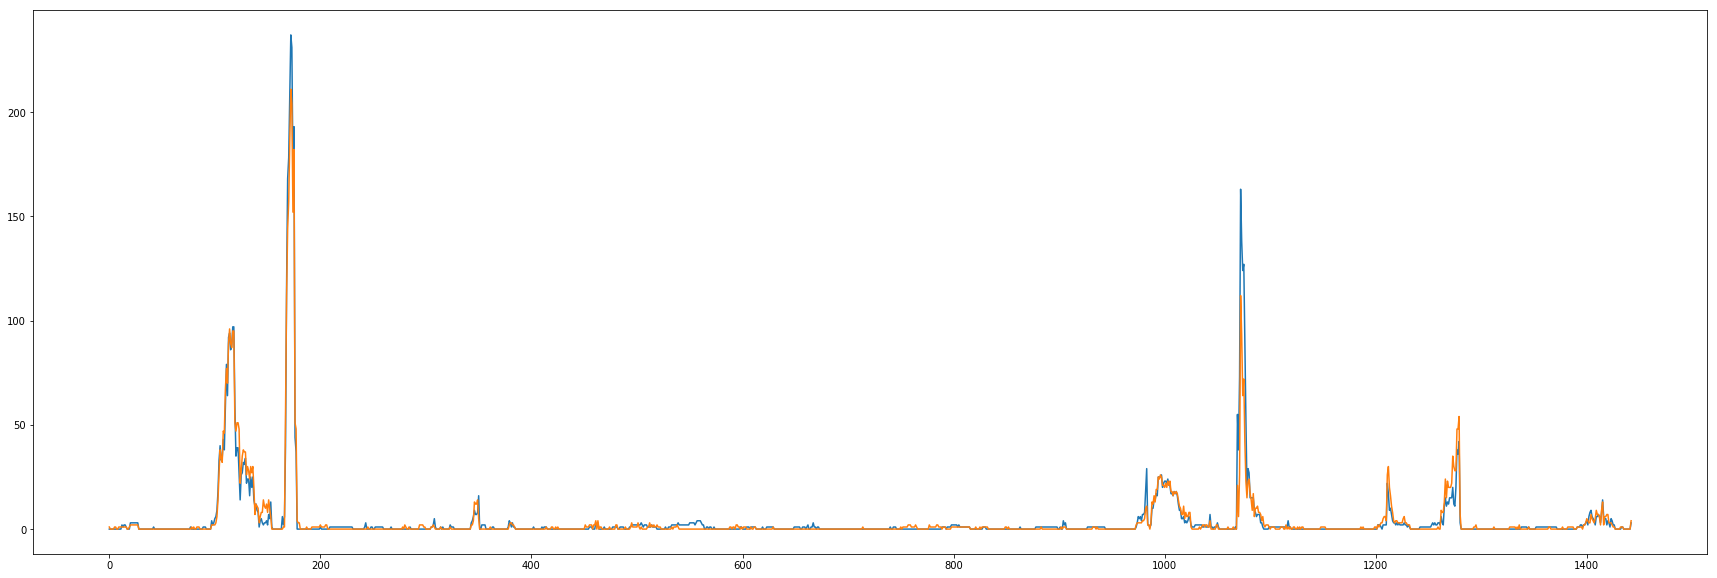

In [30]:
# Original and new results comparison via plots

new_pQTLs_df = pd.DataFrame(new_pQTLs_list, columns=["SNP", "gene", "pvalue", "qvalue", "reject"])
new_pQTLs_df.to_csv("./data/pQTLs/new_results.csv", sep='\t', index=False, na_rep='NA')
new_pQTLs_df = new_pQTLs_df[new_pQTLs_df["reject"] == True] 

old_pQTL_x, old_pQTL_y = qtls.map_linkages_to_genome_location(pQTLs_df, full_genotypes_df)
new_pQTL_x, new_pQTL_y = qtls.map_linkages_to_genome_location(new_pQTLs_df, full_genotypes_df)

plt.figure(figsize=(30, 10))
# plt.xticks(range(len(old_pQTL_x)), [s if old_pQTL_y[i] > 300 else "" for i, s in enumerate(old_pQTL_x)], rotation='vertical', size=4)
plt.plot(old_pQTL_y)
plt.plot(new_pQTL_y)
# plt.plot([-y for y in eQTL_y])
plt.savefig("./img/linkages/pQTLs_old_and_new.png", format="png", dpi=300) 

In [31]:
new_pQTLs_df = pd.read_table("./data/pQTLs/new_results.csv", sep='\t')
new_pQTLs_df = new_pQTLs_df[new_pQTLs_df["reject"] == True] 

# approach quality evaluation:
old_pQTL_linkage_pairs = set(
    (marker_name, gene_name) 
    for marker_name, gene_name in pQTLs_df[["SNP", "gene"]].values
)

common = 0
for marker_name, gene_name in new_pQTLs_df[new_pQTLs_df["reject"] == True][["SNP", "gene"]].values:
    linkage_pair = (marker_name, gene_name)
    common += linkage_pair in old_pQTL_linkage_pairs
    
print(
    "Common linkages: {}, {}%\n"
    "Old linkages, total: {}\n"
    "New linkages, total: {}\n"
    "New linkages found: {}"
    .format(common, 100 * common / pQTLs_df.shape[0], 
            pQTLs_df.shape[0], new_pQTLs_df.shape[0], 
            new_pQTLs_df.shape[0] - common)
) 

Common linkages: 3641, 59.203252032520325%
Old linkages, total: 6150
New linkages, total: 5851
New linkages found: 2210
